# Predicción de rangos para Ecobici utilizando rank diversity y GBRT

En este notebook se detalla el procedimiento para el ajuste de un modelo de regresión para el pronóstico en la actividad de tráfico en las estaciones utilizando $GBRT$ (Gradient Boosted Regression Trees) para posteriormente realizar un rankeo y medir las distancias del rankeo original contra el pronosticado. Se aplican medidas de error a los conjuntos de restaciones que pertenecen a los grupos de $Head$, $Body$ y $Tail$ y se analizan las diferencias en los errores obtenidos.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
from sklearn import preprocessing

%matplotlib inline

In [2]:
def load_daytrips():
    path = r'D:\ownCloud\Documentos posgrado\Posgrado 2do semestre\Seminario investigacion\Experimental Data\Cd Mex\Movilidad\Hist Ecobici\ecobici.csv'
    trips = pd.read_csv(path,
                    parse_dates=['date_removed', 'date_arrived'],
                    infer_datetime_format=True,
                    low_memory=False)
    
    trips = trips.loc[trips['action'] != 'C  ']

    # Find the start date
    ind = pd.DatetimeIndex(trips.date_arrived)
    trips['date'] = ind.date.astype('datetime64')
    trips['hour'] = ind.hour

    # Count trips by date
    by_date = trips.pivot_table('bike',aggfunc='count',
                            index='date',
                            columns='station_arrived', )

    # add a flag indicating weekend
    by_date['weekend'] = (by_date.index.dayofweek >= 5)
    
    by_date_weekday = by_date[by_date['weekend'] == False]

    mavg_wd = by_date_weekday.sum(axis=1).rolling(window=20,center=False).mean()
    mstd_wd = by_date_weekday.sum(axis=1).rolling(window=20,center=False).std()

    black_list = by_date_weekday.sum(axis=1)[by_date_weekday.sum(axis=1) <= mavg_wd-2*mstd_wd].index

    by_date_weekend = by_date[by_date['weekend'] == True]

    mavg_we = by_date_weekend.sum(axis=1).rolling(window=20,center=False).mean()
    mstd_we = by_date_weekend.sum(axis=1).rolling(window=20,center=False).std()

    black_list = black_list.union(by_date_weekend.sum(axis=1)[by_date_weekend.sum(axis=1) <= mavg_we-2*mstd_we].index)
    
    # remove those values on the blacklist
    by_date = by_date.fillna(0)
    by_date = by_date.loc[~by_date.index.isin(black_list)]
    
    return by_date

La predicción se realiza sobre el periodo que comprende la primer fase de funcionamiento de $Ecobici$, el cual consta de aproximadamente 662 días y 90 estaciones activas.

Los viajes cancelados en los registros fueron removidos así como los fines de semana para centrar el enfoque de predicción a la actividad entre semana.

In [3]:
by_date = load_daytrips()

station_phase_path = r'C:\Users\ghost\Google Drive\JairCastruitaGastelum\Progress Reports\Clustering_ECOBICI\DATA\ecobiciFases.csv'
station_phase = pd.read_csv(station_phase_path,header=None)
station_phase.columns = ['station','phase']

by_date.drop([col for col in list(by_date.columns.values) if col not in station_phase[station_phase['phase'] <= 1]['station'].values or col >= 260], 
        axis=1, inplace=True)

# Keep only weekdays to make a more stable count signal
by_date = by_date[by_date.index.dayofweek < 5]

phase1 = by_date['2010-02-20':'2012-10-29'].copy()

C:\Users\ghost\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Dejando al final una matriz de $T x E$, donde $T$ corresponde a los días de funcionamiento, $E$ a las estaciones. Los números situandos en $X_{te}$ son los conteos que tuvo la estación $e$ en el día $t$.

In [4]:
phase1

station_arrived,1,2,3,4,5,6,7,8,9,10,...,81,82,83,84,85,86,87,88,89,90
date,,,,,,,,,,,,,,,,,,,,,
2010-02-22,0.0,0.0,0.0,0.0,9.0,3.0,4.0,5.0,0.0,0.0,...,0.0,0.0,5.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0
2010-02-23,0.0,0.0,0.0,0.0,8.0,1.0,2.0,3.0,0.0,0.0,...,0.0,0.0,3.0,3.0,8.0,0.0,0.0,0.0,0.0,0.0
2010-02-24,0.0,1.0,0.0,4.0,2.0,2.0,3.0,1.0,2.0,1.0,...,0.0,0.0,1.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0
2010-02-25,0.0,2.0,0.0,2.0,3.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0
2010-02-26,0.0,5.0,0.0,4.0,0.0,10.0,2.0,2.0,2.0,19.0,...,0.0,0.0,1.0,3.0,39.0,0.0,0.0,0.0,0.0,0.0
2010-03-01,0.0,4.0,4.0,5.0,0.0,7.0,2.0,3.0,5.0,2.0,...,0.0,0.0,2.0,2.0,51.0,0.0,0.0,0.0,0.0,0.0
2010-03-02,0.0,6.0,10.0,2.0,4.0,6.0,5.0,1.0,2.0,1.0,...,0.0,0.0,3.0,4.0,9.0,0.0,0.0,0.0,0.0,0.0
2010-03-03,0.0,10.0,7.0,3.0,4.0,12.0,5.0,1.0,1.0,1.0,...,0.0,2.0,4.0,2.0,12.0,0.0,0.0,0.0,0.0,0.0
2010-03-04,5.0,9.0,5.0,8.0,8.0,5.0,5.0,6.0,7.0,1.0,...,0.0,1.0,5.0,6.0,12.0,0.0,0.0,0.0,0.0,0.0


La es para realizar un rankeo de las estaciones para un determinado conjunto de días utilizando un modelo de regresión que realice la predicción del tráfico de bicicletas entrantes.

Para la construcción del vector de características a utilizar se agregará el tráfico de bicicletas entrantes de la estación $e$ como la variable dependiente ($y$). Los predictores o variables independientes para cada estación serán los siguientes: el tráfico de bicicletas entrantes el día $t-1$, la media móvil de tráfico de bicicletas entrantes de 10 días antes y el día de la semana (como valores nominales).

Se realizará una partición del conjunto de datos para el entrenamiento/prueba respectivamente, en el cual para el conjunto de prueba se separarán las estaciones en sus conjuntos de Head, Body y Tail acorde a la pertenencia de cada estación para realizar una medición del error obtenido promedio más centrada en la pertenencia a la distribución en el rango.

### Diversidad de rango 

In [5]:
data = dict([(r[0], list(phase1.columns[np.argsort(list(r)[1: ])[::-1]])) \
        for r in list(phase1.to_records())])
    
dr = pd.DataFrame.from_dict(data, orient='index', dtype=None)
dr = dr.sort_index()

head = np.unique(dr[[0]])

tail = np.setdiff1d(dr[89].unique(), dr[0].unique())

body = np.setdiff1d(dr[50].unique(), head)
body = np.setdiff1d(body, tail)

Tras realizar la obtención de la diversidad en el rango, se obtuvieron todos los elementos únicos que forman parte del rango 1 ($Head$) y del rango 90 ($Tail$), Eliminando todos los elementos de $Head$ que pudieran estar presentes en el $Tail$. La distribución que corresponde a $Body$ en este caso son las estaciones complementarias que no forman parte tanto de $Head$ como $Tail$.

In [6]:
print 'Head:',head,'\n'
print 'Body:',body,'\n'
print 'Tail:',tail,'\n'

Head: [ 1  5 13 17 19 20 24 27 29 31 36 61 64 70 84 85] 

Body: [ 4  6  7 11 16 18 21 23 28 35 37 38 45 49 51 53 58 60 63 66 68 69 71 72 73
 75 76 78 79 83] 

Tail: [ 2  3  8  9 10 12 14 15 22 25 26 30 32 33 34 39 40 41 42 43 44 46 48 50 52
 54 55 57 59 62 65 67 77 80 81 82 86 87 88 89 90] 



### Convirtiendo tabla de conteos a observaciones independientes

Se transforma la matriz con los conteos por $T x E$ (phase1) en observaciones independientes, donde por cada día $t$ se obtienen 90 observaciones relacionadas a las estaciones $e$ que conforman el sistema, así, la matriz original que tenía dimensiones de 662 x 90 se transforma en una matriz de 59580 x 3, donde las columnas corresponden a la fecha, número de estación y conteo de actividad respectivamente.

In [7]:
phase_aux = phase1.transpose()
phase_transformed = pd.melt(phase_aux.reset_index(), id_vars=["station_arrived"], 
                  var_name="Date", value_name="Value").sort_values(["station_arrived",'Date'])
phase_transformed = phase_transformed.set_index('Date')

In [8]:
phase_transformed

,station_arrived,Value
Date,,
2010-02-22,1,0.0
2010-02-23,1,0.0
2010-02-24,1,0.0
2010-02-25,1,0.0
2010-02-26,1,0.0
2010-03-01,1,0.0
2010-03-02,1,0.0
2010-03-03,1,0.0
2010-03-04,1,5.0


### Agregando características a las observaciones 

Se concatena al vector de observaciones independientes predictores extra para ajustar al modelo $GBRT$. Primero se agrega el predictor de día de la semana en forma de valores nominales, donde cada valor se asocia con un día de la semana (0: lunes - 4: viernes). Por la capacidad del modelo $GBRT$ de lidiar con tipos de datos heterogeneos no es necesario transformar este predictor con dummy variables, como sí pasa con otro tipo de regresores.

In [9]:
phase_transformed['weekday'] = phase_transformed.index.dayofweek

También se contruyó otro tipo de regresor que captura el comportamiento a largo plazo del sistema: se capturó la media móvil de 10 días en el pasado del tráfico de ingresos para cada estación.

In [10]:
phase_transformed['rolling'] = phase_transformed.groupby('station_arrived')['Value'].apply(pd.rolling_mean, 10)  

C:\Users\ghost\AppData\Local\Enthought\Canopy\User\lib\site-packages\pandas\core\groupby.py:636: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  return func(g, *args, **kwargs)


Se incorporó también el conteo de ingresos que la estación tuvo el día anterior $t-1$.

In [11]:
phase_transformed['shift'] = phase_transformed.groupby('station_arrived')['Value'].shift(periods=1)

Debido a la construcción de los predictores antes mencionados, fue necesario utilizar 10 observaciones previas para la media móvil adicionalmente de la observación del día inmediato anterior para cada estación. Estas observaciones sin contenido son removidas. 

In [12]:
phase_transformed = phase_transformed.dropna()

Dejando un conjunto de vectores con la siguiente forma donde:

- $Date$: Corresponde al día de actividad $t$
- station_arrived: Corresponde a la estación observada $e$
- $Value$: Corresponde al tráfico de ingresos obtenido ese día
- $weekday$: Corresponde al día de la semana en valor nominal
- $rolling$: Media móvil obtenida de 10 días previos
- $shift$: Actividad inmediata de la estación $e$ en el día inmediato anterior $t-1$

In [13]:
phase_transformed

,station_arrived,Value,weekday,rolling,shift
Date,,,,,
2010-03-05,1,4.0,4,0.9,5.0
2010-03-08,1,12.0,0,2.1,4.0
2010-03-09,1,14.0,1,3.5,12.0
2010-03-10,1,20.0,2,5.5,14.0
2010-03-11,1,20.0,3,7.5,20.0
2010-03-12,1,27.0,4,10.2,20.0
2010-03-15,1,13.0,0,11.5,27.0
2010-03-16,1,25.0,1,14.0,13.0
2010-03-17,1,26.0,2,16.6,25.0


### Train y Test 

Para entrenamiento y evaluación se separa el conjunto de datos utilizados en conjuntos separados para cada tarea, reteniendo el mes de octubre del 2012 para evaluación y entrenando el modelo con el resto.

In [14]:
def makeData(data):
    tdata = data.transpose()
    tdata_row = pd.melt(tdata.reset_index(), id_vars=["station_arrived"], 
                      var_name="Date", value_name="Rank")

    tdata_row = tdata_row.sort_values(["station_arrived",'Rank'])
    tdata_row = tdata_row.set_index('Date')

    return tdata_row

In [15]:
train = phase_transformed[:'2012-09-29']
test = phase_transformed['2012-09-29':]

Se realiza un rankeo para la actividad de las estaciones en relación a la fecha de la forma $r_1,r_2, \dots, r_n$ donde $r_1$ corresponde a la estación con mayor actividad ese día y $r_n$ la estación con menor actividad, obteniendo una matriz de $T x E$.

In [16]:
rank1 = phase1.rank(axis='columns', ascending=False, method='first')

In [17]:
train_rank = rank1[:'2012-09-29']
test_rank = rank1['2012-09-29':]

Una vez construida la matriz de rangos y separada en conjunto de entrenamiento y prueba, se transforma a un vector de rango observado por estación en el día $t$, después se une al vector en conjunto con los predictores formados. Se realiza esto para su posterior evaluación después de realizar la predicción con el modelo ajustado.

In [18]:
train_rank_whole, test_rank_whole = makeData(train_rank), makeData(test_rank)

train = train.reset_index()
train_rank_whole = train_rank_whole.reset_index()

test = test.reset_index()
test_rank_whole = test_rank_whole.reset_index()

In [19]:
train_set = pd.merge(train, train_rank_whole, left_on=['Date','station_arrived'], right_on=['Date','station_arrived'])
X_train = train_set[['weekday','rolling','shift']]
y_train = train_set[['Value']]

test_set = pd.merge(test, test_rank_whole, left_on=['Date','station_arrived'], right_on=['Date','station_arrived'])
X_test = test_set[['weekday','rolling','shift']]
y_test = test_set[['Value']]

In [20]:
train_set

,Date,station_arrived,Value,weekday,rolling,shift,Rank
0,2010-03-05,1,4.0,4,0.9,5.0,36.0
1,2010-03-08,1,12.0,0,2.1,4.0,6.0
2,2010-03-09,1,14.0,1,3.5,12.0,8.0
3,2010-03-10,1,20.0,2,5.5,14.0,2.0
4,2010-03-11,1,20.0,3,7.5,20.0,1.0
5,2010-03-12,1,27.0,4,10.2,20.0,2.0
6,2010-03-15,1,13.0,0,11.5,27.0,1.0
7,2010-03-16,1,25.0,1,14.0,13.0,1.0
8,2010-03-17,1,26.0,2,16.6,25.0,3.0
9,2010-03-18,1,18.0,3,17.9,26.0,4.0


### Gradient Boosting Regression Trees

Los $GBRT$ son modelos de ensambles basados en la partición del espacio de características utilizando árboles de decisión de muy baja profundidad generados secuencialmente a partir de la información obtenida de su modelo anterior donde se ajusta un árbol de decisión a los residuos de un modelo ajustado anteriormente, después se agrega ese árbol al modelo ajustado en orden de adaptar los residuos (Hastie, chap 8 Introduction to statistical learning).
Los árboles de decisión funcionan bajo el modelo:
$$f(X) = \sum_{m=1}^{M}c_m \cdot 1(X \in R_m)$$
Donde $R_1,\dots, R_m$ representa una partición en el espacio de características.

Una de las fortalezas que presenta este modelo son: 
- Habilidad para representar relaciones altamente no lineales entre las variables independientes y las dependientes.
- Facilidad para manejar variables cualitativas sin la necesidad de transformarlas a dummy variables.

$GBRT$ utiliza principalmente 3 parámetros:
- Número de árboles, $B$.
- Parámetro de reducción $\lambda$.
- Número de particiones para cada árbol $d$.

Para fines de este experimento se optó por utilizar un Modelos con los parámetros $B$ = 1000, $\lambda$ = 0.1 y $d$ = 1.

### Ajuste de los datos

Se entrena un modelo con las observaciones de todas las estaciones hasta antes de 2012-09-29.
El modelo realizará una predicción acerca del tráfico de entrada que la estación $e$ recibió tuvo el día $t$.

Para el día $t$ se realiza, la predicción del tráfico se realiza para las $n$ estaciones que forman parte del sistema, después, se realiza un ranking sobre las $n$ estaciones, asignando el rango de $1$ para la estación con mayor actividad $r_1$, hasta $n$ para la estación con menor activividad $r_n$.

Las medidas de evaluación se aplican sobre las predicciónes, utilizando MSE para el conjunto de prueba.

In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

est = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1,
         max_depth=1, random_state=0, loss='ls').fit(X_train.values, y_train.values.flatten())

train_set['y_'] = est.predict(X_train.values)

In [22]:
train_set['y_rank'] = train_set.groupby('Date')['y_'].rank(ascending=False, method='first')

### MSE

### Error de entrenamiento

Para realizar una comparativa de error obtenidos en el rankeo pronosticado contra el rank, las estaciones fueron separadas de acuerdo a su aparición en la diversidad de rango, esto con la intención de segmentar la evaluación de error con respecto a la distribución en el rango. Los subconjuntos mostrados a continuación corresponden a $Head$, $Body$ y $Tail$ respectivamente.

In [23]:
Rt = train_set[train_set['station_arrived'].isin(head)]['Rank'].values.flatten()
Rt_ = train_set[train_set['station_arrived'].isin(head)]['y_rank'].values.flatten()
print 'train Head MSE:',mean_squared_error(Rt, Rt_)

train Head MSE: 93.648931962


In [24]:
Rt = train_set[train_set['station_arrived'].isin(body)]['Rank'].values.flatten()
Rt_ = train_set[train_set['station_arrived'].isin(body)]['y_rank'].values.flatten()
print 'train Body MSE:',mean_squared_error(Rt, Rt_)

train Body MSE: 135.674736287


In [25]:
Rt = train_set[train_set['station_arrived'].isin(tail)]['Rank'].values.flatten()
Rt_ = train_set[train_set['station_arrived'].isin(tail)]['y_rank'].values.flatten()
print 'train Tail MSE:',mean_squared_error(Rt, Rt_)

train Tail MSE: 112.466309046


De los resultados observados, el error disminuye considerablemente al subconjunto de $Head$ y $Tail$, mientras que en $Body$ se aprecia bastante alto.

Las siguientes medidas de evaluación son las mismas que las anteriores con la diferencia de que se tomó un submuestreo de 10 elementos para cada sección de la diversidad de rango:

### Evaluación por muestreo

La siguiente evaluación se realizó de la siguiente manera:

Se realiza un muestreo tomando 10 estaciones aleatorias para $Head$, $Body$ y $Tail$ y se obtiene el $MSE$ de las predicciones para cada grupo. Se realiza este proceso en una iteración 100 veces, seleccionando un muestreo diferente cada iteración.

In [26]:
def ErrorRank(Sample_error):
    sns.set(style="ticks", palette="muted", color_codes=True)

    # Plot the orbital period with horizontal boxes
    ax = sns.boxplot(x="Error", y="Drank", data=Sample_error,
                     whis=np.inf, color="c")

    # Add in points to show each observation
    sns.stripplot(x="Error", y="Drank", data=Sample_error,
                  jitter=True, size=3, color=".3", linewidth=0)

    ax.set_title('Box plot de errores con respecto a distribucion de rango')
    sns.despine(trim=True)

In [27]:
def SampledError(set_):
    Sample_error = pd.DataFrame({'Drank' : [],'Error' : []})

    for i in range(100):
        sample_head = head[np.random.randint(len(head),size=10)]
        sample_body = body[np.random.randint(len(body),size=10)]
        sample_tail = tail[np.random.randint(len(tail),size=10)]

        Rt = set_[set_['station_arrived'].isin(sample_head)]['Rank'].values.flatten()
        Rt_ = set_[set_['station_arrived'].isin(sample_head)]['y_rank'].values.flatten()
        Sample_error = Sample_error.append(pd.DataFrame([['Head', mean_squared_error(Rt, Rt_)]], columns=['Drank','Error']),ignore_index=True)

        Rt = set_[set_['station_arrived'].isin(sample_body)]['Rank'].values.flatten()
        Rt_ = set_[set_['station_arrived'].isin(sample_body)]['y_rank'].values.flatten()
        Sample_error = Sample_error.append(pd.DataFrame([['Body', mean_squared_error(Rt, Rt_)]], columns=['Drank','Error']),ignore_index=True)

        Rt = set_[set_['station_arrived'].isin(sample_tail)]['Rank'].values.flatten()
        Rt_ = set_[set_['station_arrived'].isin(sample_tail)]['y_rank'].values.flatten()
        Sample_error = Sample_error.append(pd.DataFrame([['Tail', mean_squared_error(Rt, Rt_)]], columns=['Drank','Error']),ignore_index=True)
        
    return Sample_error

In [28]:
Sample_error = SampledError(train_set)

El siguiente gráfico es un boxplot donde se muestran los errores obtenidos por categorías de $Head$, $Body$ y $Tail$.

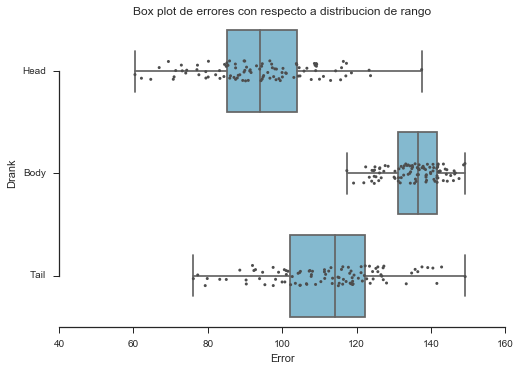

In [29]:
ErrorRank(Sample_error)

### Error de prueba

In [30]:
test_set['y_'] = est.predict(X_test.values)
test_set['y_rank'] = test_set.groupby('Date')['y_'].rank(ascending=False, method='first')

Una vez obtenido el error en la fase de entrenamiento ahora se pide al modelo realizar una prediccion sobre el conjunto de prueba para su evaluación.

In [31]:
Rt = test_set[test_set['station_arrived'].isin(head)]['Rank'].values.flatten()
Rt_ = test_set[test_set['station_arrived'].isin(head)]['y_rank'].values.flatten()
print 'Head MSE test:',mean_squared_error(Rt, Rt_)

Head MSE test: 56.2827380952


In [32]:
Rt = test_set[test_set['station_arrived'].isin(body)]['Rank'].values.flatten()
Rt_ = test_set[test_set['station_arrived'].isin(body)]['y_rank'].values.flatten()
print 'Body MSE test:',mean_squared_error(Rt, Rt_)

Body MSE test: 97.1587301587


In [33]:
Rt = test_set[test_set['station_arrived'].isin(tail)]['Rank'].values.flatten()
Rt_ = test_set[test_set['station_arrived'].isin(tail)]['y_rank'].values.flatten()
print 'Tail MSE test:',mean_squared_error(Rt, Rt_)

Tail MSE test: 81.8722415796


De la misma manera se realiza la misma evaluación ahora tomando una muestra de 10 elementos para $Head$, $Body$ y $Tail$:

In [34]:
Sample_error = SampledError(test_set)

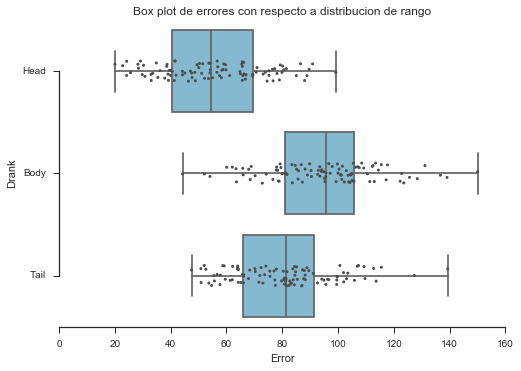

In [35]:
ErrorRank(Sample_error)

### Conclusiones:

Con los resltados obtenidos en este notebook podemos realizar las siguientes conjeturas:

- Como se obterva en los boxplots anteriores, los cuartiles en $Head$ y $Body$ están bien separados tanto para el conjunto de entrenamiento como el de prueba.
- Los errores que se obtuvieron para $Tail$ se encuentran en un punto intermedio, mostrando un grado elevado de predictibilidad ante $Body$ pero menor que $Head$.
- Aunque los errores obtenidos para $Head$ son los menores, la magnitud de error es bastante alta aún. Esto puede deberse a diferentes motivos, estaciones de $Body$ que terminaron por motivos varios en el primer rango y después decayeron en frecuencia de uso con el tiempo, la utilización de un conjunto de prueba donde es evidente que existe una tendencia (esto posiblemente mejore si se acota el conjunto de entrenamiento a un periodo más reciente), entre otras.
- Aunque las medidas de error no son tan bajas como se espera quizá esto pueda mejorar al utilizar una medida de error más adecuada para ranking como lo es $NDCG$.